In [38]:
# 标准库
import os
import time
import re
import pathlib
import textwrap
import datetime
import openai
# 第三方库
import numpy as np
import srt
import soundfile as sf
from tqdm import tqdm

# 项目相关库
import whisper
from datasets import load_dataset
from openai import OpenAI

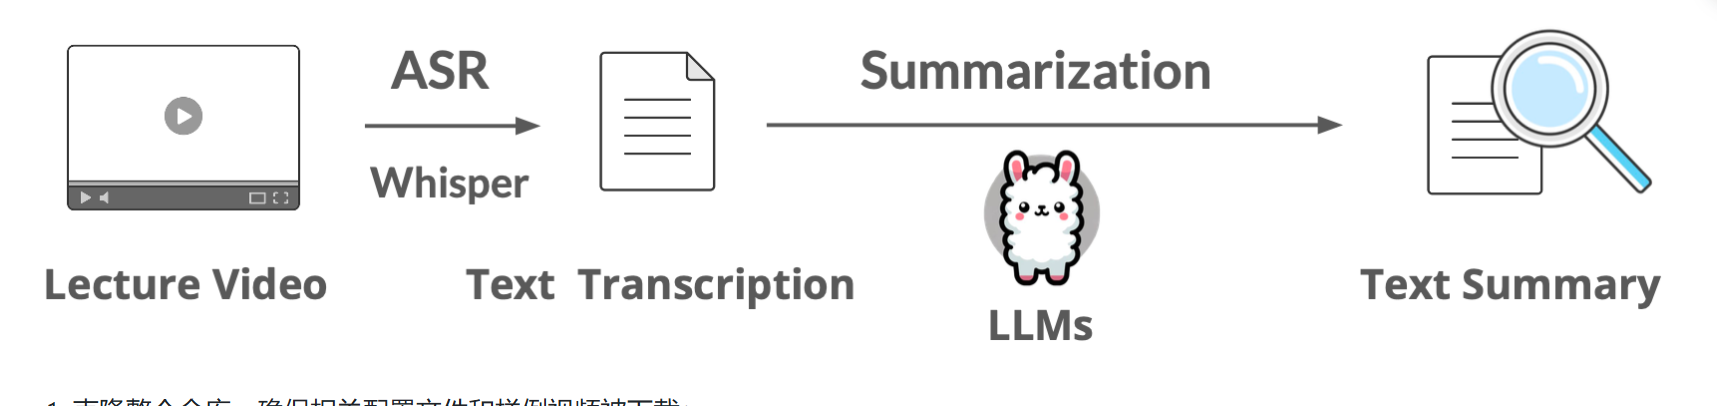

In [2]:
# 加载本地 Parquet 格式的数据集
dataset = load_dataset('parquet', data_files={'test': './test-00000-of-00001.parquet'})

# 准备音频
input_audio = dataset["test"]["audio"][0]
# input_audio_name = input_audio["path"]
input_audio_name='audio.mp3'
input_audio_array = input_audio["array"].astype(np.float32)
sampling_rate = input_audio["sampling_rate"]

In [ ]:
# # 那如果我们想使用 .mp3 文件而不是这个从来没见过的文件格式的话，应该怎么办呢？
# import librosa
# mp3_file_path='./audio.mp3'
# input_audio_name=os.path.basename(mp3_file_path)
# # 加载音频文件指定采样率为16000
# audio, sr = librosa.load(mp3_file_path, sr=16000)
# # # 打印音频数据的采样率和形状，确保加载成功
# print(sr)

# print(audio.shape)

# print(f'现在我们转录音频{input_audio_name}为文本...')


16000
(16720000,)
现在我们转录音频audio.mp3为文本...


input_audio_array：音频数据的 NumPy 数组表示。

sampling_rate：音频的采样率（Hz）。

input_audio_name：音频文件名，仅保留文件名，不包含路径。

注意：我们使用 sr=16000，将音频采样率转换为 Whisper 模型要求的 16000 Hz，确保模型能够正确处理音频数据。

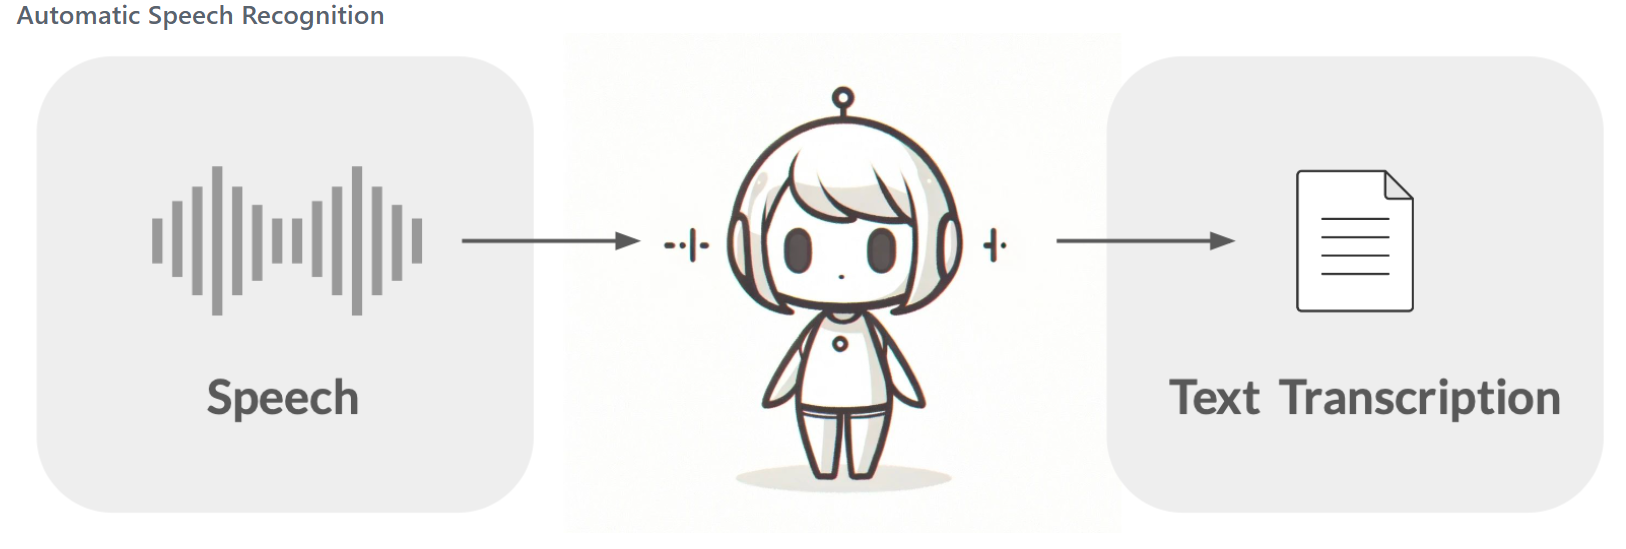

In [3]:
# 自动动语音识别 (ASR)
def speech_recognition(model_name, input_audio, output_subtitle_path, decode_options, cache_dir="./"):
    # 加载模型
    model = whisper.load_model(name=model_name, download_root=cache_dir)

    # 转录音频
    transcription = model.transcribe(
        audio=input_audio,
        language=decode_options["language"],
        verbose=False,
        initial_prompt=decode_options["initial_prompt"],
        temperature=decode_options["temperature"]
    )

    # 处理转录结果，生成字幕文件
    subtitles = []
    for i, segment in enumerate(transcription["segments"]):
        start_time = datetime.timedelta(seconds=segment["start"])
        end_time = datetime.timedelta(seconds=segment["end"])
        text = segment["text"]
        subtitles.append(srt.Subtitle(index=i, start=start_time, end=end_time, content=text))

    srt_content = srt.compose(subtitles)

    # 保存字幕文件
    with open(output_subtitle_path, "w", encoding="utf-8") as file:
        file.write(srt_content)

    print(f"字幕已保存到 {output_subtitle_path}")

In [4]:
# 模型名称，可选 'tiny', 'base', 'small', 'medium', 'large-v3'
model_name = 'medium'

# 语言
language = 'zh'  # 选择语音识别的目标语言，如 'zh' 表示中文

# 初始 prompt，可选
initial_prompt = '请用中文'  # 如果需要，可以为 Whisper 模型设置初始 prompt 语句

# 采样温度，控制模型的输出多样性
temperature = 0.0  # 0 表示最确定性的输出，范围为 0-1

# 输出文件后缀
suffix = '信号与人生'

# 字幕文件路径
output_subtitle_path = f"./output-{suffix}.srt"

# 模型缓存目录
cache_dir = './'

In [7]:
# 构建解码选项
decode_options = {
    "language": language,
    "initial_prompt": initial_prompt,
    "temperature": temperature
}

# 运行 ASR ，确保你能访问外网下载model，可以用系统代理
speech_recognition(
    model_name=model_name,
    input_audio=input_audio_array,
    output_subtitle_path=output_subtitle_path,
    decode_options=decode_options,
    cache_dir=cache_dir
)

100%|█████████████████████████████████████| 1.42G/1.42G [00:39<00:00, 38.8MiB/s]
100%|██████████| 104500/104500 [01:53<00:00, 917.08frames/s]

字幕已保存到 ./output-信号与人生.srt


In [ ]:
# import re

# text = "今天是2023年11月20日"
# result = re.sub(r'\d+', 'X', text)
# print(result)  # 输出: 今天是X年X月X日

今天是X年X月X日


In [8]:
# 读取并打印字幕内容
def extract_and_save_text(srt_filename, output_filename):
    with open(output_subtitle_path, 'r', encoding='utf-8') as file:
        content = file.read()
    # 去除时间戳和索引
    pure_text = re.sub(r'\d+\n\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}\n', '', content)
    pure_text = re.sub(r'\n\n+', '\n', pure_text)
    # 保存纯文本
    with open(output_filename, 'w', encoding='utf-8') as output_file:
        output_file.write(pure_text)
    print(f'提取的纯文本已保存至{output_filename}')
    return pure_text

    

In [9]:
# 拆分文本 有按照字数拆分和按照句子拆分两种方式，下面以字数拆分为例。
def chunk_text(text, max_length):
    return textwrap.wrap(text, max_length)

In [10]:
# 进行文本处理
# 文本块长度
chunk_length = 512

# 提取文本并拆分
pure_text = extract_and_save_text(
    srt_filename=output_subtitle_path,
    output_filename=f"./output-{suffix}.txt",
)

chunks = chunk_text(text=pure_text, max_length=chunk_length)

提取的纯文本已保存至./output-信号与人生.txt


In [14]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig
import torch

In [15]:
# 使用大语言模型
model = AutoModelForCausalLM.from_pretrained(
    './Breeze-7B-Instruct-v0_1',
    # 自动分配模型层到可用设备（如多个 GPU 或 CPU），优化计算资源。
    device_map='auto',
    # 允许运行模型自定义代码（某些模型需要此选项才能加载
    trust_remote_code=True,
    # 量化配置
    quantization_config=BitsAndBytesConfig(
        # 启用 4 位量化量化可大幅减少显存占用，使大模型能在消费级 GPU 上运行
        load_in_4bit=True,
        # 算时使用 bfloat16 精度，平衡速度和数值稳定性。
        bnb_4bit_compute_dtype=torch.bfloat16,
        # 启用双精度量化，可提升模型精度。
        bnb_4bit_use_double_quant=True,
        # 量化类型，可选 nf4（非负四位）、nb4（非负八位）、bf16（单精度）、df16（双精度）。使用 NormalFloat4 (NF4) 量化方案（适合正态分布权重，比常规 4-bit 更精确）。
        bnb_4bit_quant_type='nf4'
    )
)

2025-08-19 12:28:55.257715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 12:28:55.446856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755577735.519415   12845 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755577735.540330   12845 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755577735.722640   12845 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [39]:
# openai api model
key=(os.getenv('OPENAI_API_KEY'))
model=(os.getenv('OPENAI_MODEL'))
base_url=(os.getenv('OPENAI_BASE_URL'))
client=openai.OpenAI(
    api_key=key,
    base_url=base_url
)
try:
    response = client.chat.completions.create(
        model=model,
        messages=[{'role': 'user', 'text': '测试'}],
        max_tokens=100,
    )
    print('API设置成功',response)
except openai.APIError as e:
    print("Openai设置错误\n")
    print(e)

API设置成功 ChatCompletion(id='as-00xvwjwzc3', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="It seems like your message might not have come through as intended. Could you please clarify or provide more details about what you're asking? I'm here to help!", refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None))], created=1755578852, model='qwen3-235b-a22b', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=34, prompt_tokens=12, total_tokens=46, completion_tokens_details=None, prompt_tokens_details=None))


In [ ]:
# 本地模型实在是太慢了
# tokenizer = AutoTokenizer.from_pretrained('MediaTek-Research/Breeze-7B-Instruct-v0_1')
# tokenizer.padding_side = "right" # 设置了tokenizer的padding方向为右侧(right)
# tokenizer.pad_token = tokenizer.eos_token # 将pad_token设置为与eos_token相同
# def data_formulate(data):
#     messages = [
#         {"role": "system", "content": '用 300 个字以内写出这段视频文本的摘要，其中包括要点和所有重要细节'},
#         {"role": "user", "content": data['prompt']},
#     ]
#     # apply_chat_template函数将messages转换为模型可接受的prompt,tokenize=False表示不分词
#     prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
#     return prompt

In [ ]:
# def summarization(text):
#     """文本摘要生成函数
    
#     Args:
#         text (str): 输入文本
        
#     Returns:
#         str: 模型生成的摘要文本
#     """
#     # 输入数据处理
#     data = {'prompt': text}  # 将输入文本包装为字典格式
#     inputs = tokenizer(
#         data_formulate(data),  # 格式化对话数据
#         return_tensors="pt"    # 返回PyTorch张量
#     ).to('cuda')              # 将数据移动到GPU
    
#     # 生成配置设置
#     generation_config = GenerationConfig(
#         do_sample=False,       # 使用确定性生成（非随机采样）
#         max_new_tokens=200,    # 限制最大生成长度
#         pad_token_id=tokenizer.pad_token_id  # 设置填充token
#     )
    
#     # 模型生成
#     output = model.generate(
#         **inputs,
#         generation_config=generation_config
#     )
    
#     # 结果解码处理
#     decoded_output = tokenizer.batch_decode(
#         output,
#         skip_special_tokens=True  # 跳过特殊token
#     )[0]
    
#     # 提取模型生成部分（去除指令模板）
#     output_text = decoded_output.split('[/INST] ')[1]
    
#     return output_text

In [41]:
# 模型名称
model_name = (os.getenv('OPENAI_MODEL'))

# 控制响应的随机性
temperature = 0.0

# 控制多样性
top_p = 1.0

# 最大生成标记数
max_tokens = 512

In [40]:
def summarization(client, summarization_prompt, model_name="Doubao", temperature=0.0, top_p=1.0, max_tokens=512):
    response = client.chat.completions.create(
        messages=[{"role": "user", "content": summarization_prompt}],
        model=model_name,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens
    )
    return response.choices[0].message.content

In [42]:
# 定义摘要提示模板
summarization_prompt_template = "用 300 个字以内写出这段视频文本的摘要，其中包括要点和所有重要细节：<text>"

# 对每个文本块生成摘要
paragraph_summaries = []
for index, chunk in enumerate(chunks):
    print(f"\n========== 正在生成第 {index + 1} 段摘要 ==========\n")
    print(f"原始文本 (第 {index + 1} 段):\n{chunk}\n")
    
    # 构建摘要提示
    summarization_prompt = summarization_prompt_template.replace("<text>", chunk)
    
    # 调用摘要函数
    summary = summarization(
        client=client,
        summarization_prompt=summarization_prompt,
        model_name=model_name,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens
    )
    
    # 打印生成的摘要
    print(f"生成的摘要 (第 {index + 1} 段):\n{summary}\n")
    
    # 将生成的摘要保存到列表
    paragraph_summaries.append(summary)


========== 正在生成第 1 段摘要 ==========

原始文本 (第 1 段):
每次说 学问是做出来的 什么意思 要做 才会获得学问 你如果每天光是坐在那里听 学问很可能是左耳近右耳出的 你光是坐在那儿读 学问可能从眼睛进入脑海之后就忘掉了 如何能够学问在脑海里面 真的变成你自己学问 就是要做 可能有很多同学有这个经验 你如果去修某一门课 或者做某一个实验 在期末就是要教一个final project 那个final project就是要你把 学到的很多东西 最后整合在你的final project里面 最后做出来的时候 就是把它们都整合了 当你学期结束 真的把final project做完的时候 你会忽然发现 我真的学到很多东西 那就是做出来的学问 也许可以举另外一个例子 就是你如果学了某一些 很复杂的演算法或者什么 好像觉得那些不见得在你的脑海里 可是后来老师出了个习题 那个习题叫你写一个很大的程式 要把所有东西都包进去 当你把这个程式写完的时候 你会发现 你忽然把演算法 所有东西都弄通了 那就是学问是做出来的 所以我们永远要记得 尽量多动手多做 在动手跟做的过程之中 学问才可以变成是自己的 同样的情形就是说 很多时候这样动手或者做的 表现或者成绩 没有一个成绩单上的数字

生成的摘要 (第 1 段):
这段视频强调“学问是做出来的”这一核心观点，指出只有通过实践，知识才能真正内化为自己的能力。光听讲或阅读，知识容易遗忘；唯有动手实践，如完成期末项目或编写复杂程序，才能整合所学、深入理解。视频提到，当学生完成需要综合运用知识的作业或项目时，会明显感受到自身成长，这就是“做中学”的体现。此外，动手实践的成果往往无法单用成绩衡量，但对学习的提升至关重要。总结：实践让学问真正属于自己。


========== 正在生成第 2 段摘要 ==========

原始文本 (第 2 段):
使得很多人觉得那不重要 很多人甚至觉得 这门课要做final project 我就不修了太累了 或者说那门课需要 怎么样太累我就不要做了 而不知道 其实那个才是让你做的机会 然后可以学到最多 也就是说虽然很可能 那么辛苦的做很多事 没有让你获得什么具体成绩 对你的overfitting可能没有帮助 可是对你的全面学习 是很有帮助是该学的 不要漏掉这些事 这是我所说的

In [44]:
# 合并段落摘要
collected_summaries = "\n".join(paragraph_summaries)

# 定义最终摘要提示模板
final_summarization_prompt = "在 500 字以左右写出以下文字的简洁摘要：<text>"
final_summarization_prompt = final_summarization_prompt.replace("<text>", collected_summaries)

# 生成最终摘要
final_summary = summarization(
    client=client,
    summarization_prompt=final_summarization_prompt,
    model_name=model_name,
    temperature=temperature,
    top_p=top_p,
    max_tokens=max_tokens
)

print(final_summary)

这段视频围绕“学问是做出来的”这一核心观点展开，强调实践对学习的重要性。知识只有通过动手实践，如完成项目、编写程序等，才能真正内化为个人能力。视频指出，课堂外的学习同样关键，如打球、旅行、社交、参与社团等，都能促进成长与思考能力的提升。此外，软实力如沟通、合作、领导力等对个人发展至关重要，虽不体现在成绩中，却需长期培养。视频还提到，学习应以长期目标为导向，结合实力、努力、自我管理与正确方向，持续积累，才能实现长远发展。总结：学习不仅是知识的获取，更是通过实践、反思与多元体验，实现能力与人格的全面提升。


In [ ]:
# 方法二：精炼方法（the method of Refinement) - Refine
# Refinement 就是把每次的文本和之前的摘要结合起来丢给大模型，类似于迭代：
# 步骤（Pipeline）如下：

# 第1步：从一小部分数据开始，运行prompt生成初始输出。
# 第2步：对后续每个文档，将前一个输出与新文档结合输入。
# 第3步：LLM 根据新文档中的信息精炼输出。
# 第4步：此过程持续迭代，直到处理完所有文档。


In [45]:
# 定义初始摘要提示模板
summarization_prompt_template = "用 300 个字以内写出这段视频文本的摘要，其中包括要点和所有重要细节:<text>"

# 定义精炼摘要提示模板
summarization_prompt_refinement_template = "请在 500 字以内，结合原先的摘要和新的内容，提供简洁的摘要:<text>"

# 初始化保存摘要的列表
refined_summaries = []

# 对文本块逐步进行精炼摘要，并打印中间过程
for index, chunk in enumerate(chunks):
    if index == 0:
        # 第一步：对第一段文本生成初始摘要
        print(f"\n========== 正在生成第 {index + 1} 段的初始摘要 ==========\n")
        print(f"原始文本 (第 {index + 1} 段):\n{chunk}\n")
        
        # 构建初始摘要提示
        summarization_prompt = summarization_prompt_template.replace("<text>", chunk)
        
        # 调用摘要函数生成第一个摘要
        first_summary = summarization(
            client=client,
            summarization_prompt=summarization_prompt,
            model_name=model_name,
            temperature=temperature,
            top_p=top_p,
            max_tokens=max_tokens
        )
        
        # 打印生成的初始摘要
        print(f"生成的摘要 (第 {index + 1} 段):\n{first_summary}\n")
        
        # 保存生成的摘要
        refined_summaries.append(first_summary)

    else:
        # 后续步骤：结合前一个摘要与当前段落进行精炼
        print(f"\n========== 正在生成第 {index + 1} 段的精炼摘要 ==========\n")
        print(f"原始文本 (第 {index + 1} 段):\n{chunk}\n")
        
        # 构建精炼摘要的输入文本，将前一个摘要与当前段落内容结合
        chunk_with_previous_summary = f"前 {index} 段的摘要: {refined_summaries[-1]}\n第 {index + 1} 段的内容: {chunk}"
        
        # 构建精炼摘要提示
        summarization_prompt = summarization_prompt_refinement_template.replace("<text>", chunk_with_previous_summary)
        
        # 调用摘要函数生成精炼摘要
        refined_summary = summarization(
            client=client,
            summarization_prompt=summarization_prompt,
            model_name=model_name,
            temperature=temperature,
            top_p=top_p,
            max_tokens=max_tokens
        )
        
        # 打印生成的精炼摘要
        print(f"生成的摘要 (第 {index + 1} 段):\n{refined_summary}\n")
        
        # 保存生成的精炼摘要
        refined_summaries.append(refined_summary)

# 最终的精炼摘要结果就是 refined_summaries 列表的最后一个元素
final_refined_summary = refined_summaries[-1]

print("\n========== 最终精炼摘要结果 ==========\n")
print(final_refined_summary)


========== 正在生成第 1 段的初始摘要 ==========

原始文本 (第 1 段):
每次说 学问是做出来的 什么意思 要做 才会获得学问 你如果每天光是坐在那里听 学问很可能是左耳近右耳出的 你光是坐在那儿读 学问可能从眼睛进入脑海之后就忘掉了 如何能够学问在脑海里面 真的变成你自己学问 就是要做 可能有很多同学有这个经验 你如果去修某一门课 或者做某一个实验 在期末就是要教一个final project 那个final project就是要你把 学到的很多东西 最后整合在你的final project里面 最后做出来的时候 就是把它们都整合了 当你学期结束 真的把final project做完的时候 你会忽然发现 我真的学到很多东西 那就是做出来的学问 也许可以举另外一个例子 就是你如果学了某一些 很复杂的演算法或者什么 好像觉得那些不见得在你的脑海里 可是后来老师出了个习题 那个习题叫你写一个很大的程式 要把所有东西都包进去 当你把这个程式写完的时候 你会发现 你忽然把演算法 所有东西都弄通了 那就是学问是做出来的 所以我们永远要记得 尽量多动手多做 在动手跟做的过程之中 学问才可以变成是自己的 同样的情形就是说 很多时候这样动手或者做的 表现或者成绩 没有一个成绩单上的数字

生成的摘要 (第 1 段):
这段视频强调“学问是做出来的”这一观点，指出只有通过实践，知识才能真正内化为自己的学问。光听讲或阅读容易遗忘，而动手实践，如完成期末项目或编写复杂程序，能有效整合所学，加深理解。视频提到，当学生完成需要综合运用知识的作业时，会明显感受到自身成长，这就是“做中学”的体现。此外，实践带来的收获往往无法用成绩单上的数字衡量。核心在于：多动手、多实践，学问才能真正属于自己。


========== 正在生成第 2 段的精炼摘要 ==========

原始文本 (第 2 段):
使得很多人觉得那不重要 很多人甚至觉得 这门课要做final project 我就不修了太累了 或者说那门课需要 怎么样太累我就不要做了 而不知道 其实那个才是让你做的机会 然后可以学到最多 也就是说虽然很可能 那么辛苦的做很多事 没有让你获得什么具体成绩 对你的overfitting可能没有帮助 可是对你的全面学习 是很有帮助是该学的 不要漏掉这些事 这是我所说的 

In [48]:
# 总结与展望
# 对深度学习一窍不通也可以做出 AI 应用吗？
# 当然可以！或许你曾经看到 AI 视频小助手的时候会觉得：“哇，肯定很多技术细节在里面，学习曲线一定很陡峭。”但实际上，在真正用到模型的地方，你只需要加载预训练模型和调用 API 就可以了，完全不需要自己训练模型：

# 音频提取：从视频中提取音频，这一步可以通过各种工具实现，比如 ffmpeg。
# 语音识别：使用开源的 ASR（自动语音识别）模型，如 OpenAI 的 Whisper，将音频转换为文字。
# 文本摘要：借助大语言模型（LLM）对文本进行摘要，可以直接调用 OpenAI API 或其他大模型 API 实现。
# 因此，所有这些看似复杂的任务其实都是你可以轻松做到的。AI 应用并没有想象中那么神秘，只要你了解工具的使用方法，就可以轻松去实现你的想法。

# 🤔再打开一下思路：现在，大多数的视频都有字幕或者 AI 字幕，这为我们提供了一个捷径。通过直接下载这些字幕，你的 AI 应用就能跳过音频转录等步骤，直接进入它最擅长的环节：生成摘要。

# So，让我们再次回到最初的疑问：AI 视频小助手真的“看”视频了吗？

# 答：不仅没看，还大概率没听。如果某个线上的 AI 小助手在可以正常下载到音频的情况下却不能做总结，这就表示：它读的是字幕。

# 可能的疑问
# 摘要没有提供时间段，还是做不到和评论区的小助手一样的事情。

# 确实，目前我们生成的摘要并没有包含具体的时间戳信息，不像一些评论区的 AI 小助手那样，为每个摘要段落提供对应的视频时间点。这是因为我们在 extract_and_save_text() 处理的时候就把时间戳信息拿掉了，为什么这样做呢？

# 答：提供一个简单的处理概览，以及对齐作业 :)

# 如何解决这个问题？

# 答：文本处理时保留时间戳 + 修改 prompt 模版，增加 <start_time> - <end_time> 占位符。

# 这篇文章更多的作为一个入门文章，希望能帮你揭开面纱的一角。

In [ ]:
# print(summarization('你好，欢迎来到 Dive into Deep Learning 视频小助手！'))

欢迎来到 Dive into Deep Learning 视频小助手！我们将为您提供关于深层学习的重要信息和建议。我们将讨论不同的模型、算法和实践，帮助您更好地理解和应用深层学习。请随时提供您的问题和建议，我们将尽力回答和提供帮助。让我们开始吧！


In [ ]:
# # 对每个文本块生成摘要
# paragraph_summaries = []
# for index, chunk in enumerate(chunks):
#     print(f"\n========== 正在生成第 {index + 1} 段摘要 ==========\n")
#     print(f"原始文本 (第 {index + 1} 段):\n{chunk}\n")
    
#     # 构建摘要提示
#     # summarization_prompt = summarization_prompt_template.replace("<text>", chunk)
    
#     # 调用摘要函数
#     summary = summarization(
#         chunk,
#     )
    
#     # 打印生成的摘要
#     print(f"生成的摘要 (第 {index + 1} 段):\n{summary}\n")
    
#     # 将生成的摘要保存到列表
#     paragraph_summaries.append(summary)


========== 正在生成第 1 段摘要 ==========

原始文本 (第 1 段):
每次说 学问是做出来的 什么意思 要做 才会获得学问 你如果每天光是坐在那里听 学问很可能是左耳近右耳出的 你光是坐在那儿读 学问可能从眼睛进入脑海之后就忘掉了 如何能够学问在脑海里面 真的变成你自己学问 就是要做 可能有很多同学有这个经验 你如果去修某一门课 或者做某一个实验 在期末就是要教一个final project 那个final project就是要你把 学到的很多东西 最后整合在你的final project里面 最后做出来的时候 就是把它们都整合了 当你学期结束 真的把final project做完的时候 你会忽然发现 我真的学到很多东西 那就是做出来的学问 也许可以举另外一个例子 就是你如果学了某一些 很复杂的演算法或者什么 好像觉得那些不见得在你的脑海里 可是后来老师出了个习题 那个习题叫你写一个很大的程式 要把所有东西都包进去 当你把这个程式写完的时候 你会发现 你忽然把演算法 所有东西都弄通了 那就是学问是做出来的 所以我们永远要记得 尽量多动手多做 在动手跟做的过程之中 学问才可以变成是自己的 同样的情形就是说 很多时候这样动手或者做的 表现或者成绩 没有一个成绩单上的数字

生成的摘要 (第 1 段):
学问是做出来的，意味着要通过实际操作和做来获得知识。仅仅坐在那里听课或读书，知识可能会忘记。为了使学问真正成为自己的，应该多动手做，例如完成期末的final project或写一个大的程式。在做过程中，知识会整合在一起，并会发现自己真的学到了很多东西。


========== 正在生成第 2 段摘要 ==========

原始文本 (第 2 段):
使得很多人觉得那不重要 很多人甚至觉得 这门课要做final project 我就不修了太累了 或者说那门课需要 怎么样太累我就不要做了 而不知道 其实那个才是让你做的机会 然后可以学到最多 也就是说虽然很可能 那么辛苦的做很多事 没有让你获得什么具体成绩 对你的overfitting可能没有帮助 可是对你的全面学习 是很有帮助是该学的 不要漏掉这些事 这是我所说的 这个课业内可以做的这些事 刚才我们讲到思考的时候 我觉得我漏掉一点 你如果修我的信号课 你可能会发现 我上课没讲到一个数学试字的

KeyboardInterrupt: 